In [1]:
import warnings
warnings.filterwarnings("ignore") 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from pathlib import Path

2024-07-12 10:26:26.623864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 10:26:26.624012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 10:26:26.777018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Image data generator 
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

In [3]:
train_data = train_gen.flow_from_directory(
"/kaggle/input/faceshape-processed/dataset/train",
target_size = (48, 48),
batch_size = 64,
color_mode = "grayscale",
class_mode="categorical")

test_data = test_gen.flow_from_directory(
"/kaggle/input/faceshape-processed/dataset/test",
target_size = (48, 48),
batch_size = 64,
color_mode = "grayscale",
class_mode="categorical")

Found 3981 images belonging to 5 classes.
Found 998 images belonging to 5 classes.


In [4]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu', input_shape=(48, 48, 1)),
    Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

cnn_model.compile(optimizer="adam", 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

history = cnn_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=test_data,
    validation_steps=validation_steps,
    shuffle=True
)

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 443ms/step - accuracy: 0.2050 - loss: 6.0283 - val_accuracy: 0.2354 - val_loss: 3.1333
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2344 - loss: 3.1401 - val_accuracy: 0.3158 - val_loss: 3.1254
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - accuracy: 0.2467 - loss: 2.9984 - val_accuracy: 0.3021 - val_loss: 2.6856
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 2.7194 - val_accuracy: 0.1842 - val_loss: 2.7729
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.3152 - loss: 2.6134 - val_accuracy: 0.3729 - val_loss: 2.3960
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 2.3233 - val_accuracy: 0.3947 - val_loss: 2.3813
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.3774 - loss: 2.3464 - val_accuracy: 0.3646 - val_loss: 2.2212
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3281 - loss: 2.2451 - val_accuracy: 0.5000

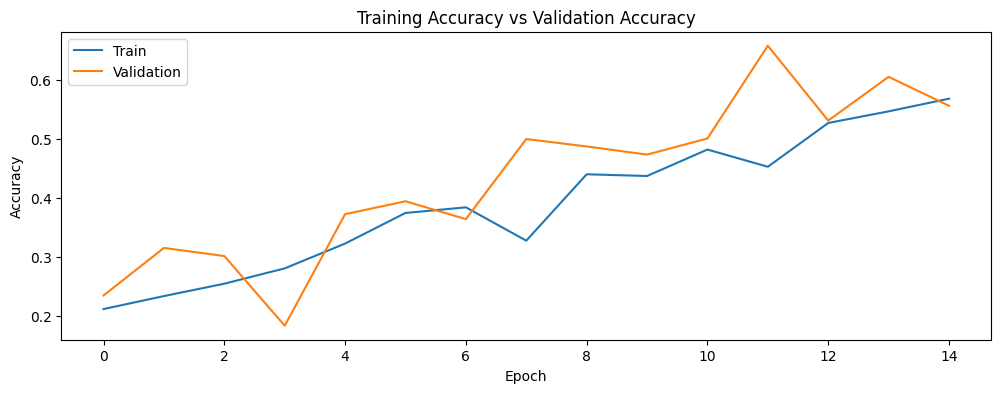

In [5]:
fig , ax = plt.subplots(1, 1)
train_acc = history.history['accuracy']
fig.set_size_inches(12,4)

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Training Accuracy vs Validation Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train','Validation'])

In [6]:
# Convert the model to JSON and save it to a file
model_structure = cnn_model.to_json()
path = Path("/kaggle/working/groveOn_model.json")
path.write_text(model_structure)

# Save the model
cnn_model.save('/kaggle/working/groveOn_model.h5')